In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import numpy as np
import os.path as osp
from tf_lab.iclr.evaluator import Evaluator
from general_tools.in_out.basics import files_in_subdirs
from geo_tool import Point_Cloud
from tf_lab.iclr.helper import stored_synthetic_samples
from tf_lab.evaluate.generative_pc_nets import coverage, minimum_mathing_distance
from collections import defaultdict
import collections
from tf_lab.point_clouds.convenience import compute_structural_loss

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
class_name = 'chair'
boost_samples = 3
split = 'val'
matching_metric = 'chamfer'

In [5]:
evaluator = Evaluator(class_name)
evaluator.load_gt_data()

In [6]:
gt_data = evaluator.gt_data[split]

In [7]:
top_syn_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/'

voxel_samples = osp.join(top_syn_dir, 'voxel_based/gmm/ae_chair_phuoc_data_64_voxels_64_bneck/samples.npz')

pc_samples = osp.join(top_syn_dir, 'gmm/gmm_emd_' + class_name+ '/bneck_128_full_32_gaussians.npz')

In [8]:
evaluator.prepare_sample_data(voxel_samples, boost_samples)

voxel_samples = evaluator.sample_data[split]
temp = np.zeros_like(voxel_samples)
for i, v in enumerate(voxel_samples):
    temp[i] = Point_Cloud(v).rotate_z_axis_by_degrees(-90).points
voxel_samples = temp

evaluator.prepare_sample_data(pc_samples, boost_samples)
pc_samples = evaluator.sample_data[split]

In [17]:
# rid = np.random.randint(len(pc_samples))
# Point_Cloud(pc_samples[rid]).plot();
# Point_Cloud(voxel_samples[rid]).plot();

In [128]:
use_emd = True
if matching_metric == 'emd':
    use_emd = True
batch_size = 400

In [129]:
mathed_idx, matched_dists = coverage(voxel_samples, gt_data, batch_size=batch_size, normalize=True, 
                                     use_EMD=use_emd, ret_dist=True)
voxel_covered = np.array(mathed_idx)
voxel_matched_dists = np.array(matched_dists)

mathed_idx, matched_dists = coverage(pc_samples, gt_data, batch_size=batch_size, normalize=True, 
                                     use_EMD=use_emd, ret_dist=True)
pc_covered = np.array(mathed_idx)
pc_matched_dists = np.array(matched_dists)

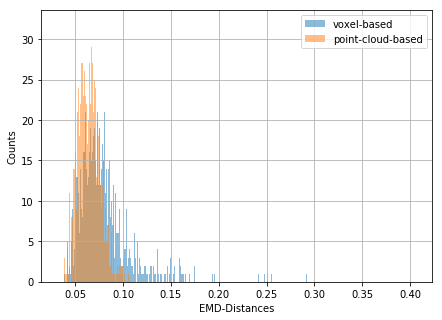

In [136]:
def plot_two_histograms():
    import matplotlib.pylab as plt
    all_dists = np.vstack([pc_matched_dists, voxel_matched_dists])

    all_dists /= 2048.0

    min_bound = np.min(all_dists) - np.min(all_dists) * 0.01
    max_bound = np.max(all_dists) + np.max(all_dists) * 0.01

    cut_thres = 0.4
    max_bound = cut_thres + cut_thres * 0.01

    n_bins = 500
    bins = np.linspace(min_bound, max_bound, n_bins)

    x = voxel_matched_dists.copy() / 2048.0
    y = pc_matched_dists.copy() / 2048.0

    x[x >= cut_thres] = cut_thres
    y[y >= cut_thres] = cut_thres

    plt.figure(figsize=(7,5))
    plt.hist(x, bins, alpha=0.5, label='voxel-based')
    plt.hist(y, bins, alpha=0.5, label='point-cloud-based')
    plt.xlabel('EMD-Distances')
    plt.ylabel('Counts')
    plt.grid()
    plt.legend(loc='upper right')
    # plt.show()
    plt.savefig('emd_dist_voxel_64_vs_pc.pdf')

In [140]:
gt_to_pc, pc_min_dists = coverage(gt_data, pc_samples, batch_size=batch_size, normalize=True, 
                                  use_EMD=use_emd, ret_dist=True)
gt_to_pc = np.array(gt_to_pc)
pc_min_dists = np.array(pc_min_dists)

In [141]:
v_cov = set(voxel_covered)
p_cov = set(pc_covered)
missed_by_points = list(v_cov.difference(p_cov))

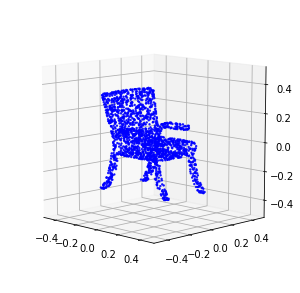

480


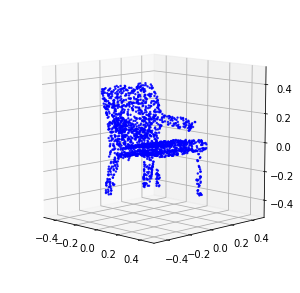

720


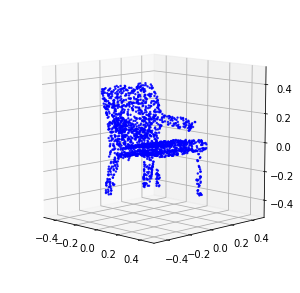

910


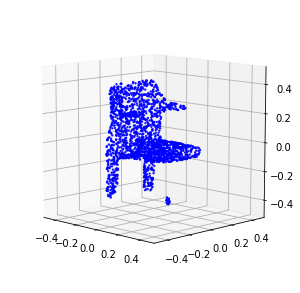

In [186]:
i = 9
mi = missed_by_points[i]
gt_fig = Point_Cloud(gt_data[mi]).plot(azim=-45)
Point_Cloud(pc_samples[gt_to_pc[mi]]).plot();
f = []
for j in np.where(voxel_covered == mi)[0]:
        print j
    fig = Point_Cloud(voxel_samples[j]).plot(azim=-45);
    f.append(fig)